In [ ]:
import matplotlib.pyplot as plt 
from google.colab import drive 
import tensorflow as tf
from tensorflow.data import Dataset
import tensorflow.keras as keras 
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import tensorflow.keras as keras
image_list = []
drive.mount('/content/Drive')
directory = '/content/Drive/MyDrive/IF_Norte_Vapor_Agua/'
tf.__version__


Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


'2.9.2'

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   24G   85G  22% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  910M  54% /sbin/docker-init
tmpfs           6.4G   48K  6.4G   1% /var/colab
/dev/sda1        65G   41G   25G  63% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  713M   15G   5% /content/Drive


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

In [ ]:
tamanho_da_imagem = (200, 200)
tipo_de_cor = 'grayscale'
train_dataset = keras.utils.image_dataset_from_directory(directory,
                                              labels = None,
                                              color_mode = 'grayscale',
                                              image_size=tamanho_da_imagem)

Found 4547 files belonging to 1 classes.


In [ ]:
mapas_train_images = []
for images in train_dataset:
    for i in range(len(images)):
      mapas_train_images.append(images[i])
      
m_images = np.array(mapas_train_images)
print(m_images.shape)
m_images = m_images.reshape(m_images.shape[0],200,200,)

(4547, 200, 200, 1)


In [ ]:
linhas = 200 #pixels 200x200
colunas = 200
canais = 1 #canais em modo ciza
noise_input_dim = 100 # a dimensão do noise_vector é arbitrária 
img_shape = (linhas, colunas, canais)

In [ ]:
def rede_geradora(img_shape, noise_dim): 
  modelo = keras.models.Sequential()
  modelo.add(keras.layers.Dense(28, input_dim=noise_dim))
  modelo.add(keras.layers.LeakyReLU(alpha=0.01))
  modelo.add(keras.layers.Dense(56))
  modelo.add(keras.layers.LeakyReLU(alpha=0.02))
  modelo.add(keras.layers.Dense(112))
  modelo.add(keras.layers.LeakyReLU(alpha=0.02))
  row,column,channel = img_shape 
  modelo.add(keras.layers.Dense(row*column*channel, activation='tanh'))
  modelo.add(keras.layers.Reshape(img_shape))
  return modelo 

def rede_discriminadora(img_shape): 
  modelo = keras.models.Sequential()
  modelo.add(keras.layers.Flatten(input_shape = img_shape))
  modelo.add(keras.layers.Dense(112))
  modelo.add(keras.layers.LeakyReLU(alpha=0.02))
  modelo.add(keras.layers.Dense(56))
  modelo.add(keras.layers.LeakyReLU(alpha=0.02))
  modelo.add(keras.layers.Dense(28))
  modelo.add(keras.layers.LeakyReLU(alpha=0.01))
  modelo.add(keras.layers.Dense(1, activation='sigmoid'))
  return modelo 


In [ ]:
def VanillaGAN(rede_geradora, rede_discriminativa):
  modelo = keras.models.Sequential()
  modelo.add(rede_geradora)
  modelo.add(rede_discriminativa)
  return modelo

gerador = rede_geradora(img_shape, noise_input_dim)
discriminador = rede_discriminadora(img_shape)
discriminador.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
discriminador.trainable = False
gan = VanillaGAN(gerador, discriminador)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam())

In [ ]:
perdas = []
acuracias = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
   X_train = m_images
   
   X_train = X_train.reshape(X_train.shape[0], 200, 200, 1).astype('float32')
   
   X_train = (X_train - 127.5) / 127.5 

   real = np.ones((batch_size, 1))

   fake = np.zeros((batch_size, 1))

   for iteration in range(iterations):

     idx = np.random.randint(0,X_train.shape[0], batch_size) 
     imgs = X_train[idx] 

     z = np.random.normal(0,1,(batch_size, 100)) 
     gen_imgs = gerador.predict(z)
     
     d_loss_real = discriminador.train_on_batch(imgs, real)
     d_loss_fake = discriminador.train_on_batch(gen_imgs, fake) 
     d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

     z = np.random.normal(0,1, (batch_size, 100))
     gen_imgs = gerador.predict(z)
     g_loss = gan.train_on_batch(z, real) 
     perdas.append((d_loss, g_loss)) 
     iteration_checkpoints.append(iteration + 1)
     acuracias.append(100.0 * accuracy)
     if (iteration + 1) % sample_interval == 0:
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))
        sample_images(gerador, iteration) 

def sample_images(generator,iteration, image_grid_rows=4, image_grid_columns=4):

  z = np.random.normal(0,1,(image_grid_rows * image_grid_columns, noise_input_dim))
  
  gen_imgs = generator.predict(z)

  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(200,200), sharey=True, sharex=True)

  cnt = 0

  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      axs[i,j].axis('off')
      cnt += 1 
  plt.savefig('/content/Drive/MyDrive/treinamento_gan3/'+str(iteration)+'.jpg')



In [ ]:
%%time 
iterations = 4000
batch_size = 32
sample_interval = 500

train(iterations, batch_size, sample_interval)

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 27ms/step
2000 [D loss: 0.114576, acc.: 98.44%] [G loss: 3.451245]
1/1 [==============================] - 0s 28ms/step
2500 [D loss: 0.264516, acc.: 89.06%] [G loss: 3.408212]
1/1 [==============================] - 0s 36ms/step
3000 [D loss: 0.422541, acc.: 87.50%] [G loss: 9.824400]
1/1 [==============================] - 0s 27ms/step
3500 [D loss: 0.190119, acc.: 93.75%] [G loss: 4.477804]
1/1 [==============================] - 0s 27ms/step
4000 [D loss: 0.033231, acc.: 96.88%] [G loss: 3.912537]
1/1 [==============================] - 0s 27ms/step
CPU times: user 28min 3s, sys: 56.1 s, total: 28min 59s
Wall time: 26min
Error in callback <function flush_figures at 0x7f80380a4050> (for post_execute):


KeyboardInterrupt: ignored

[ 6.25   50.     50.     ... 98.4375 93.75   96.875 ]


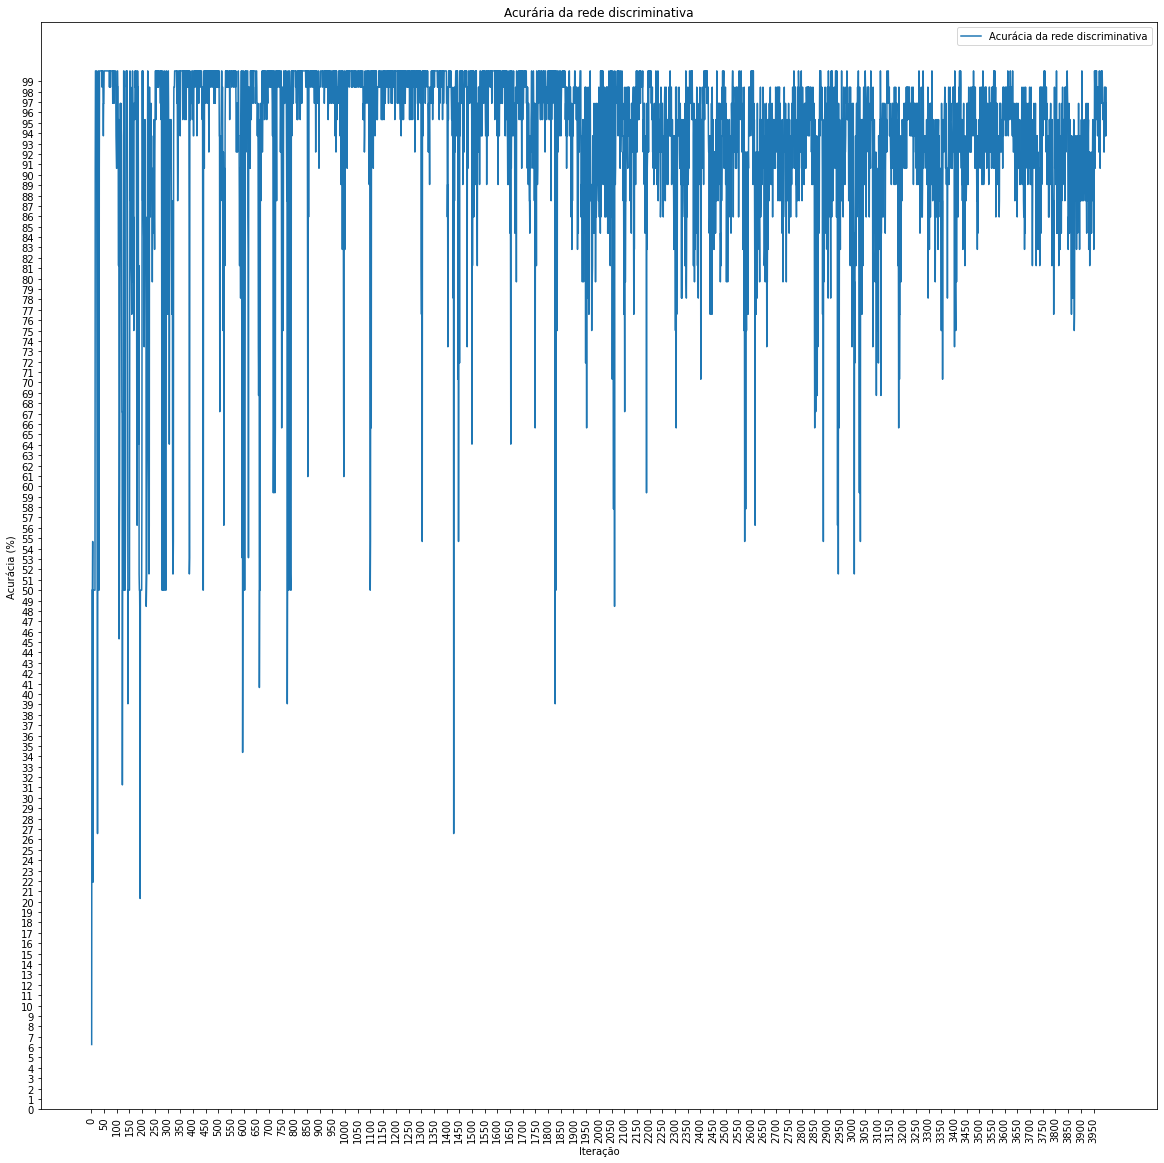

In [ ]:
acuracias = np.array(acuracias)

# Plot Discriminator accuracy
plt.figure(figsize=(20, 20))

plt.plot(iteration_checkpoints, acuracias, label="Acurácia da rede discriminativa")

plt.xticks(range(0,4000,50), rotation=90)
plt.yticks(range(0, 100, 1))

plt.title("Acurária da rede discriminativa")
plt.xlabel("Iteração")
plt.ylabel("Acurácia (%)")
plt.legend()



In [ ]:
print(np.mean(acuracias))
print(np.std(acuracias))

92.95703125
9.976099826536593


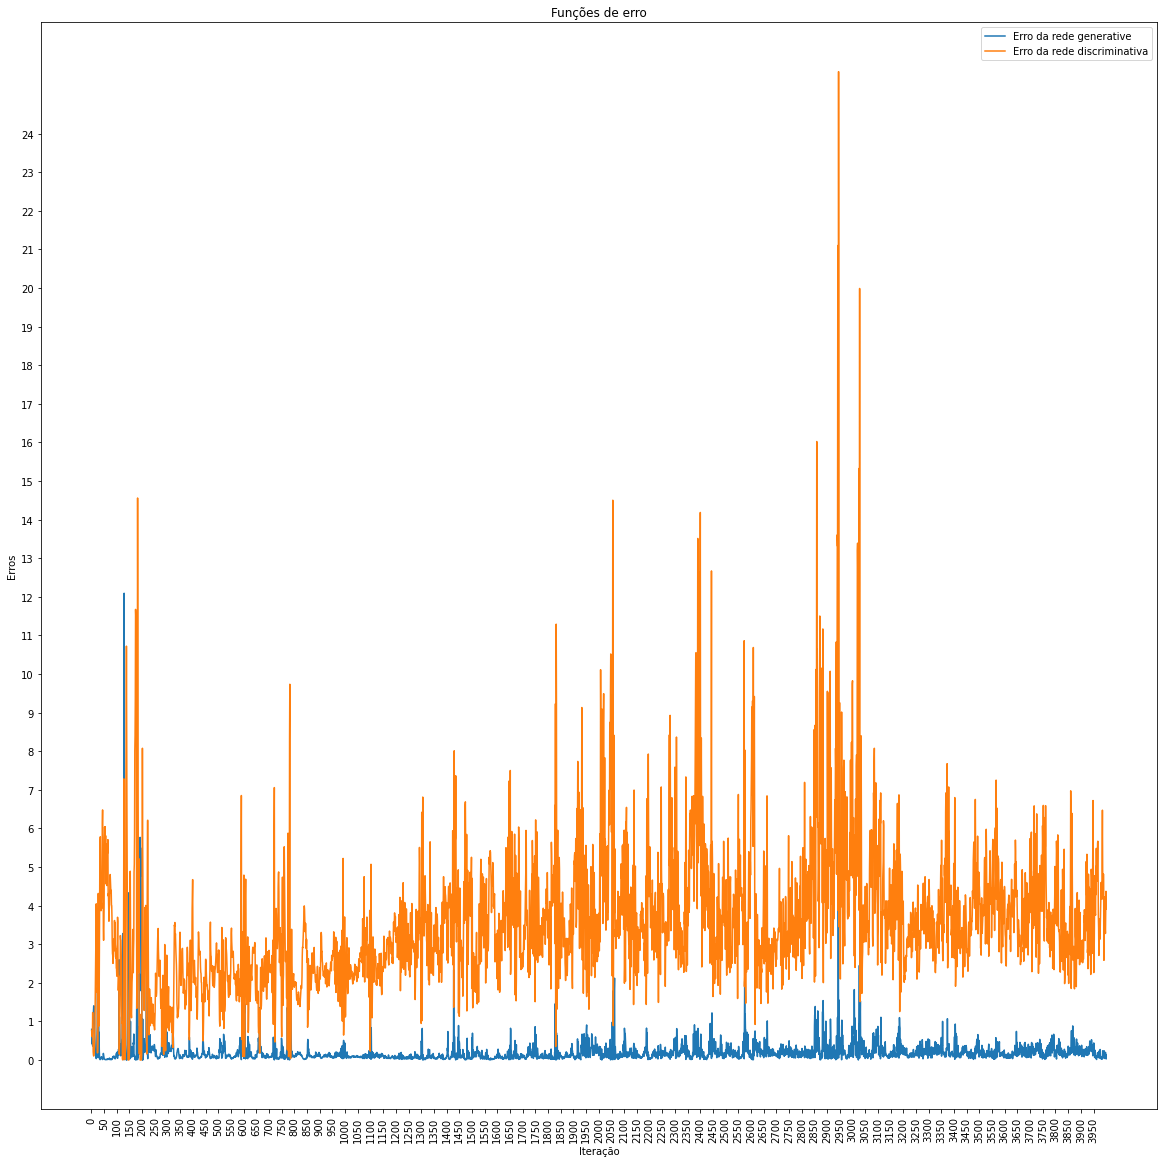

In [ ]:
losses = np.array(perdas)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(20, 20))
plt.plot(iteration_checkpoints, losses.T[0], label="Erro da rede generative")
plt.plot(iteration_checkpoints, losses.T[1], label="Erro da rede discriminativa")

plt.xticks(iteration_checkpoints, rotation=90)
plt.xticks(range(0,4000,50), rotation=90)
plt.yticks(range(0, 25, 1))

plt.title("Funções de erro")
plt.xlabel("Iteração")
plt.ylabel("Erros")
plt.legend()

In [ ]:
generator_loss = []
discriminator_loss = []
for loss in perdas:
  dloss, gloss = loss
  generator_loss.append(gloss)
  discriminator_loss.append(dloss)

print(np.mean(generator_loss))
print(np.std(generator_loss))
print(np.mean(discriminator_loss))
print(np.std(discriminator_loss))



3.5637085313994104
1.8161306689134442
0.23010783592078593
0.41229915879911894


In [ ]:
print(dloss)

3.912537097930908
